## Time-series analysis of the Normalised Difference Water Index (NDWI) from Sentinel-2     during the 2021 drought in Uttarakhand’s Terai region

### Introduction :
Over the years, Uttarakhand's Terai region have been noted to have experienced seasonal drought period. The latest of these drought occurences was in 2021. An analysis to examine the spatial distribution of the effect of the area of interest using sentinel-2 imageries is to be conducted using Google Earth Engine (GEE) Python API.

Firstly, I will Import Google Earth Engine Python and authenticate it

In [1]:
#import GEE python API
import ee
#Authenticate
ee.Authenticate()

Enter verification code: 4/1AdQt8qjHUFnNYe05hKEiTF8yf_Ed_mdEjcI7s6PD6iSgkiVtyKopXXTBcO0

Successfully saved authorization token.


In [195]:
#Initialize GEE
ee.Initialize()

In [192]:
#importing important python libraries
import geemap as gm
import matplotlib.pyplot as plt
import time
import json
import os
import requests
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON
import folium
from datetime import datetime as dt
import pandas as pd
import altair as alt
import geojson

# allow images to display
from IPython.display import Image

#magic command
%matplotlib inline

### Area of Interest (AOI) :
The area of interest is Uttarakhand. To delineate this, a shapefile of the area of interest have been uploaded to GEE assets thereby creating a Feature collection and consequently pulled into this notebook

In [4]:
#Defining area of interest(Terai)
#importing GEE Feature Collection
utta = ee.FeatureCollection("users/Adeolu/utta")

In [193]:
geom = utta.geometry()

In [214]:
#creating a GeeMap empty map canvas
aoi = gm.Map(center = [30.340907609005814, 79.02625123013941], zoom = 6)
#add imported shapefile
aoi.addLayer(utta)
#add map control tools     
aoi.addLayerControl()

# display area of interest
aoi

Map(center=[30.340907609005814, 79.02625123013941], controls=(WidgetControl(options=['position', 'transparent_…

### Data Collection:
After establishing the area of interest, next is to start collecting the sentinel-2 images for the drought period from July, 2011 to the end of the end of the drought.

In [231]:
#create empty map canvas
Map = gm.Map(center = [29.734597684044125, 79.97382199903063], zoom = 6)
#add layer control tools to map
Map.addLayerControl()
#display map
Map

Map(center=[29.734597684044125, 79.97382199903063], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
#declare relative file path
file_path = os.path.abspath('./data/uttarakhand.json')

#read file using python with open tool
if not os.path.exists(file_path):
    url = 'https://drive.google.com/uc?export=download&id=1cQOHH_N_cNdTWpAnYb1tNkyt8SDdnTpj'
    r = requests.get(url)
    with open(file_path, 'w') as f:
        f.write(r.content.decode("utf-8"))
#load json file
with open(file_path) as f:
    json_data = json.load(f)

In [9]:
#convert to GeoJSON format
json_layer = GeoJSON(
    data=json_data,
    name='Uttarakhand JSON',
    hover_style={'fillColor': 'red', 'fillOpacity': 0.5},
)
#add GeoJSON as a layer to map
Map.add_layer(json_layer)

In [10]:
#determine polygon geometry using GEE
coords = json_data['features'][0]['geometry']['coordinates']
poi = ee.Geometry.Polygon(coords)

Modified from https://geemap.org/notebooks/07_geojson/

#### Declaring important functions that will be used in the course of analysis of imageries.

In [197]:
#Creates a region reduction function that return the mean of the pixels intersecting the area of interest

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """
  
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

Code Block from https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/time-series-visualization-with-altair/index.ipynb#scrollTo=YfTfhCiX8Ew4

In [198]:
#converts features props to dictionary
def fc_to_dict(fc):
    prop_names = fc.first().propertyNames()
    prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

    return ee.Dictionary.fromLists(prop_names, prop_lists)

Code Block from https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/time-series-visualization-with-altair/index.ipynb#scrollTo=YfTfhCiX8Ew4

In [199]:
#renaming pandas dataframe columns
def add_date_info(df):
    df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
    df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
    df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
    df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
    df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
    return df

Code Block from https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/time-series-visualization-with-altair/index.ipynb#scrollTo=YfTfhCiX8Ew4

#### Creating an GEE ImageCollection of sentinel-2A images of the AOI under the time in consideration.

Sentinel-2A was chosen for this analysis because they have been instrumentally corrected for cloud interference

In [234]:
#function that adds the system start time to images in an imagecollection
def add_image_bands(image):
    return image.addBands(image.metadata('system:time_start'))

def clipcol(image):
    clipimage = image.clip(utta)
    return clipimage
      
sentinel_coll = ee.ImageCollection('COPERNICUS/S2_SR')\
    .filterDate('2021-07-01','2022-02-28')\
    .filterBounds(utta)\
    .map(clipcol)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

rgb = {'min': 1, 'max': 3000, 'bands': ['B2', 'B3', 'B4']};

Map.addLayer(sentinel_coll.median(), rgb, 'RGB Median');
Map

Map(bottom=7074.0, center=[29.734597684044125, 79.97382199903063], controls=(WidgetControl(options=['position'…

### The Normalized Difference Water Index (NDWI)

The NDWI results from the following equation: Index = (NIR - MIR) / (NIR + MIR) using Sentinel-2 Band 8 (NIR) and Band 12 (MIR). The NDWI is a vegetation index sensitive to the water content of vegetation and is complementary to the NDVI. 

From https://foodsecurity-tep.net/S2_NDWI#:~:text=The%20NDWI%20results%20from%20the,is%20complementary%20to%20the%20NDVI.

#### Generating Various NDWI Layers For The AOI

In [239]:
#Defining image collection
images = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(utta)
    .filterDate('2021-07-01', '2022-02-28')
    .map(add_image_bands)
    .sort("CLOUD_COVERAGE_ASSESSMENT", False)
)

#function which calculate ndwi, rename and add a 'NDWI' layer
def add_ndwi (image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands(ndwi)

#Mapping ndwi function over the image collection
sentinel_ndwi = images.map(add_ndwi);

In [240]:
#Select NDWI layer from ndwi image collection
ndwi_2021 = sentinel_ndwi.filterDate('2021-07-01', '2022-02-28').select('NDWI')

# Define specific visualization parameters for the NDWI and visualize it.
ndwi_Params = {min: -0.1, max: 0.5, 'palette': ['red', 'yellow', 'green', 'blue']};

#add selected ndwi to map layer
Map.addLayer(ndwi_2021.median().clip(utta), ndwi_Params, 'NDWI median');

In [243]:
#select ndwi median for period of drought
drought_median = sentinel_ndwi.filterDate('2021-07-01', '2021-08-31')\
        .select('NDWI')\
        .median()

#add drought_median layer to Map
Map.addLayer(drought_median.clip(utta), ndwi_Params, 'Drought Median')

#select ndwi median for post drought
postdrought_median = sentinel_ndwi\
              .filterDate('2021-12-01', '2022-02-28')\
              .select('NDWI')\
              .median()

#add postdrought_median layer to Map
Map.addLayer(postdrought_median.clip(utta), ndwi_Params, 'Post-Drought Median')


#Calculate ndwi difference between drought_median and postdrought_median

ndwi_diff = drought_median.subtract(postdrought_median).clip(utta);

#ndwi difference visualisation parameter
dndviParams = {min: -1, max: 1, 'palette': ['orange', 'LimeGreen','white', 'brown']};

Map.addLayer(ndwi_diff, dndviParams, 'NDWI diff Image');
# print(ndwi_diff, 'NDWI difference Image)');

#Display different map layers
Map

Map(bottom=7074.0, center=[29.734597684044125, 79.97382199903063], controls=(WidgetControl(options=['position'…

#### Each Map Layer can be viewed by toggling the geemap layer icon

### Generating Statistics from NDWI values

In [244]:
#filter an image collection of the AOI under the period in review
ndwi_coll = sentinel_ndwi.filterDate('2021-07-01', '2022-02-28').select('NDWI')

#reducer function that returns mean of pixels
reduce_ndwi = create_reduce_region_function(
    geometry=geom, reducer=ee.Reducer.mean(), scale=1000, crs='EPSG:4326')

#mapping reducer function to reduce each image
ndwi_stats_fc = ee.FeatureCollection(ndwi_coll.map(reduce_ndwi)).filter(
    ee.Filter.notNull(ndwi_coll.first().bandNames()))

modified from https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/time-series-visualization-with-altair/index.ipynb#scrollTo=qwtO27KMIemk

In [21]:
#Export to GEE asset
task = ee.batch.Export.table.toAsset(
    collection=ndwi_stats_fc,
    description='ndwi_stats_fc export',
    assetId='users/Adeolu/ndwi_stats_fc')
task.start()

In [48]:
#View Export Task Status
task.status()

{'state': 'COMPLETED',
 'description': 'ndwi_stats_fc export',
 'creation_timestamp_ms': 1658124161414,
 'update_timestamp_ms': 1658124753455,
 'start_timestamp_ms': 1658124172123,
 'task_type': 'EXPORT_FEATURES',
 'destination_uris': ['https://code.earthengine.google.com/?asset=projects/earthengine-legacy/assets/users/Adeolu/ndwi_stats_fc'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 2.2515385150909424,
 'id': '5PQJRYCHBCVC5RJWLBRRLODY',
 'name': 'projects/earthengine-legacy/operations/5PQJRYCHBCVC5RJWLBRRLODY'}

In [246]:
#Import GEE asset into the notebook
dwi_stat_fc = ee.FeatureCollection('users/Adeolu/ndwi_stats_fc')

In [247]:
ndwi_dict = fc_to_dict(ndwi_stat_fc).getInfo()

#comverting to pandas dataframe
ndwi_df = pd.DataFrame(ndwi_dict)
display(ndwi_df)
print(ndwi_df.dtypes)

NDWI         millis          system:index
0    -0.033191  1626586852302  00000000000000000000
1    -0.015065  1626586834588  00000000000000000001
2    -0.004847  1626586826828  00000000000000000002
3    -0.021712  1627450849073  00000000000000000003
4    -0.004835  1627450826880  00000000000000000004
...        ...            ...                   ...
1066 -0.315251  1645162839365  0000000000000000042a
1067 -0.395088  1644903055006  0000000000000000042b
1068 -0.338911  1645335062901  0000000000000000042c
1069 -0.252554  1643434817597  0000000000000000042d
1070 -0.259083  1645162817299  0000000000000000042e

[1071 rows x 3 columns]

NDWI            float64
millis            int64
system:index     object
dtype: object


In [245]:
#call add_date_info function to prepare df for plotting
ndwi_df = add_date_info(ndwi_df)
ndwi_df

NDWI         millis          system:index               Timestamp  \
0    -0.033191  1626586852302  00000000000000000000 2021-07-18 05:40:52.302   
1    -0.015065  1626586834588  00000000000000000001 2021-07-18 05:40:34.588   
2    -0.004847  1626586826828  00000000000000000002 2021-07-18 05:40:26.828   
3    -0.021712  1627450849073  00000000000000000003 2021-07-28 05:40:49.073   
4    -0.004835  1627450826880  00000000000000000004 2021-07-28 05:40:26.880   
...        ...            ...                   ...                     ...   
1066 -0.315251  1645162839365  0000000000000000042a 2022-02-18 05:40:39.365   
1067 -0.395088  1644903055006  0000000000000000042b 2022-02-15 05:30:55.006   
1068 -0.338911  1645335062901  0000000000000000042c 2022-02-20 05:31:02.901   
1069 -0.252554  1643434817597  0000000000000000042d 2022-01-29 05:40:17.597   
1070 -0.259083  1645162817299  0000000000000000042e 2022-02-18 05:40:17.299   

      Year  Month  Day  DOY  
0     2021      7   18  199  
1     2021      7   18  199  
2     2021      7   18  199  
3     2021      7   28  209  
4     2021      7   28  209  
...    ...    ...  ...  ...  
1066  2022      2   18   49  
1067  2022      2   15   46  
1068  2022      2   20   51  
1069  2022      1   29   29  
1070  2022      2   18   49  

[1071 rows x 8 columns]

In [21]:
#descriptive statistics of df
ndwi_df.describe()

NDWI        millis         Year        Month          Day  \
count  1071.000000  1.071000e+03  1071.000000  1071.000000  1071.000000   
mean     -0.221037  1.635408e+12  2021.232493     7.612512    15.602241   
std       0.218706  5.989524e+09     0.422619     3.710832     8.754094   
min      -0.701398  1.625203e+12  2021.000000     1.000000     1.000000   
25%      -0.396792  1.630215e+12  2021.000000     7.000000     8.000000   
50%      -0.162084  1.635227e+12  2021.000000     9.000000    16.000000   
75%      -0.024341  1.640583e+12  2021.000000    10.000000    23.000000   
max       0.101489  1.645939e+12  2022.000000    12.000000    31.000000   

               DOY  
count  1071.000000  
mean    216.246499  
std     113.008307  
min       1.000000  
25%     186.000000  
50%     246.000000  
75%     304.000000  
max     364.000000

In [22]:
#group ndwi values by monthly mean
monthly_df = ndwi_df.groupby('Month').mean()
monthly_df

NDWI        millis    Year        Day         DOY
Month                                                       
1     -0.160477  1.642333e+12  2022.0  16.255474   16.255474
2     -0.150638  1.644837e+12  2022.0  14.232143   45.232143
7     -0.120769  1.626453e+12  2021.0  16.452555  197.452555
8     -0.116453  1.629054e+12  2021.0  15.554745  227.554745
9     -0.189430  1.631678e+12  2021.0  14.934307  257.934307
10    -0.350152  1.634333e+12  2021.0  15.655405  288.655405
11    -0.366782  1.637023e+12  2021.0  15.795455  319.795455
12    -0.299119  1.639606e+12  2021.0  15.694656  349.694656

In [23]:
#sort monthly mean in ascending order
monthly_df_sorted = monthly_df.sort_values(by=['Year'], ascending=True)
monthly_df_sorted

NDWI        millis    Year        Day         DOY
Month                                                       
7     -0.120769  1.626453e+12  2021.0  16.452555  197.452555
8     -0.116453  1.629054e+12  2021.0  15.554745  227.554745
9     -0.189430  1.631678e+12  2021.0  14.934307  257.934307
10    -0.350152  1.634333e+12  2021.0  15.655405  288.655405
11    -0.366782  1.637023e+12  2021.0  15.795455  319.795455
12    -0.299119  1.639606e+12  2021.0  15.694656  349.694656
1     -0.160477  1.642333e+12  2022.0  16.255474   16.255474
2     -0.150638  1.644837e+12  2022.0  14.232143   45.232143

#### Plotting a Day of Year (DOY) chart of NDWI's

In [24]:
highlight = alt.selection(
    type='single', on='mouseover', fields=['Year'], nearest=True)

base = alt.Chart(ndwi_df).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=[0, 353], clamp=True)),
    y=alt.Y('NDWI:Q', scale=alt.Scale(domain=[-0.40, 0.1])),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')))

points = base.mark_circle().encode(
    opacity=alt.value(0),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('DOY:Q', title='DOY'),
        alt.Tooltip('NDWI:Q', title='NDWI')
    ]).add_selection(highlight)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)))

(points + lines).properties(width=800, height=300).interactive()

alt.LayerChart(...)

#### Plotting a Day of Year (DOY) chart of monthly NDWI's mean

In [25]:
highlight = alt.selection(
    type='single', on='mouseover', fields=['Year'], nearest=True)

base = alt.Chart(monthly_df_sorted).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=[0, 353], clamp=True)),
    y=alt.Y('NDWI:Q', scale=alt.Scale(domain=[-0.40, 0.1])),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')))

points = base.mark_circle().encode(
    opacity=alt.value(0),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('DOY:Q', title='DOY'),
        alt.Tooltip('NDWI:Q', title='NDWI')
    ]).add_selection(highlight)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)))

(points + lines).properties(width=600, height=300).interactive()

alt.LayerChart(...)

#### More Statistics

In [251]:
#define a new image collection
startDate = '2021-07-01'
endDate = '2022-02-28'

gif_ndwi = sentinel_ndwi.select('NDWI').filterDate('2021-07-01', '2022-02-28')

def custom_fun(n):
    date = ee.Date(startDate).advance(n,'month')
    m = date.get("month")
    y = date.get("year")
    dic = ee.Dictionary({
        'Date':date.format('yyyy-MM')
    })
    
    tempNDVI = (gif_ndwi.filter(ee.Filter.calendarRange(y, y, 'year'))
                .filter(ee.Filter.calendarRange(m, m, 'month'))
                .mean()
                .reduceRegion(
                    reducer = ee.Reducer.mean(),
                    geometry = poi,
                    scale = 250))
    return dic.combine(tempNDVI)

modis_YrMo = ee.List.sequence(0, 8-1).map(custom_fun)

dataframe = pd.DataFrame(modis_YrMo.getInfo())

In [252]:
dataframe

Date      NDWI
0  2021-07 -0.131200
1  2021-08 -0.120952
2  2021-09 -0.210259
3  2021-10 -0.399521
4  2021-11 -0.451519
5  2021-12 -0.344506
6  2022-01 -0.216643
7  2022-02 -0.182732

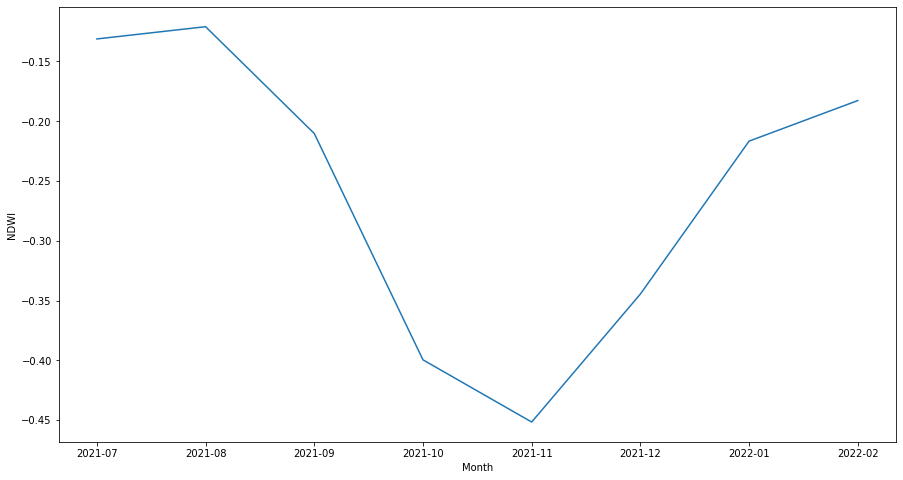

In [261]:
fig = plt.figure(figsize=(15, 8))

x = dataframe['Date'] # X-axis points
y = dataframe['NDWI']  # Y-axis points
plt.xlabel('Month')
plt.ylabel('NDWI')

plt.plot(x, y)  # Plot the chart
plt.show()

## Imageries Movie

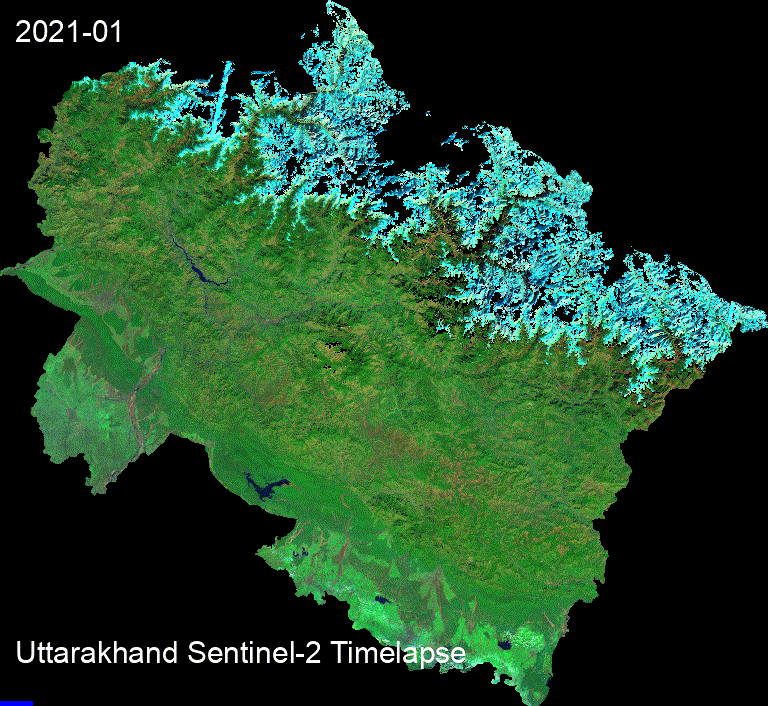

In [272]:
from IPython.display import Image
with open('./data/uttarakhand.gif','rb') as file:
    display(Image(file.read()))

### Conclusion

The analysis of the sentinel imageries from the Uttarakhand area of the Terai region and the calculation of the temporal variation of the associated NDWI values have given a clear picture on the nature of the effect of drought in the AOI over the period of study.
The NDWI imageries obtained showed that some of the area where the drought impact was most severe includes: 
**Haldawani, Nainital(Jim Corbett), Dehradun, Kausani** areas of the AOI.